<a href="https://colab.research.google.com/github/Tantawy1/Machinelearning/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-8-f90d3673d2c0>:12: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/2016_Accidents_UK.csv")
<ipython-input-8-f90d3673d2c0>:28: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  processed_df.fillna(processed_df.mean(), inplace=True)


Confusion Matrix for KNN:
[[21765  1008]
 [ 4264   288]]

Confusion Matrix for Naive Bayes:
[[22094   679]
 [ 4288   264]]

Confusion Matrix for Logistic Regression:
[[22763    10]
 [ 4543     9]]

Confusion Matrix for Neural Networks:
[[22753    20]
 [ 4525    27]]

Classifier Performance:
{'Classifier': 'KNN', 'Accuracy': 0.8013833992094862, 'CV Mean Score': 0.805372974134982, 'CV Std Score': 0.020709978557488094, 'AUC': 0.5108161425784257}
{'Classifier': 'Naive Bayes', 'Accuracy': 0.81477821695213, 'CV Mean Score': 0.8164373438567498, 'CV Std Score': 0.0008440430563269642, 'AUC': 0.5941139906297633}
{'Classifier': 'Logistic Regression', 'Accuracy': 0.8283194261455131, 'CV Mean Score': 0.8300639241150826, 'CV Std Score': 8.641237312559489e-05, 'AUC': 0.6066684103990504}
{'Classifier': 'Neural Networks', 'Accuracy': 0.8286488069096765, 'CV Mean Score': 0.8301249227852573, 'CV Std Score': 0.00019098262789691293, 'AUC': 0.6248424602038134}
Rankings based on Accuracy:
1. Neural Networks


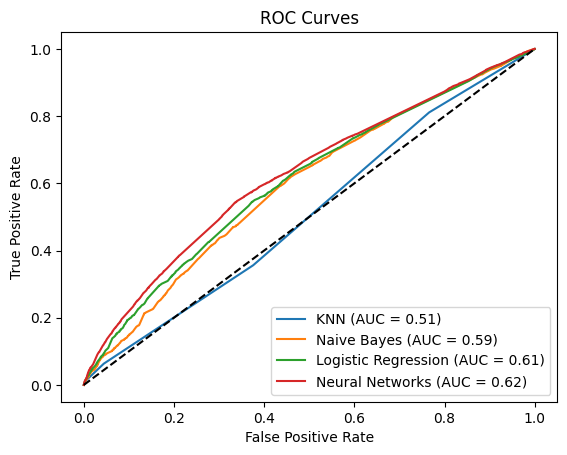

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/2016_Accidents_UK.csv")

# Select relevant columns
selected_columns = ['weather_conditions', 'road_surface_conditions', 'light_conditions', 'number_of_vehicles', 'number_of_casualties', 'speed_limit']
target_column = 'accident_severity'

# Create a new DataFrame with selected columns
processed_df = df[selected_columns + [target_column]].copy()

# Perform label encoding for text columns
text_columns = ['weather_conditions', 'road_surface_conditions', 'light_conditions']
label_encoder = LabelEncoder()
for column in text_columns:
    processed_df[column] = label_encoder.fit_transform(processed_df[column])

# Handle missing values (replace with mean)
processed_df.fillna(processed_df.mean(), inplace=True)

# Perform binary classification (severe vs. non-severe)
processed_df['accident_severity'] = processed_df['accident_severity'].apply(lambda x: 'severe' if x == 'Fatal' or x == 'Serious' else 'non-severe')

# Split the data into training, validation, and test sets
X = processed_df.drop(target_column, axis=1)
y = processed_df[target_column]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Scale the numerical features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the classifiers
classifiers = [
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Logistic Regression', LogisticRegression()),
    ('Neural Networks', MLPClassifier())
]

# Train and evaluate the classifiers
results = []
for name, classifier in classifiers:
    # Train the classifier
    classifier.fit(X_train_scaled, y_train)
    
    # Evaluate on validation set
    accuracy = classifier.score(X_val_scaled, y_val)
    
    # Perform cross-validation on training set
    cv_scores = cross_val_score(classifier, X_train_scaled, y_train, cv=5)
    mean_cv_score = cv_scores.mean()
    std_cv_score = cv_scores.std()
    
    # Predict probabilities for ROC curve on test set
    y_pred_prob = classifier.predict_proba(X_test_scaled)[:, 1]
    
    # Compute true positive rate and false positive rate for ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label='severe')
    roc_auc = auc(fpr, tpr)
    
    # Construct confusion matrix on test set
    y_pred = classifier.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    
    results.append({
        'Classifier': name,
        'Accuracy': accuracy,
        'CV Mean Score': mean_cv_score,
        'CV Std Score': std_cv_score,
        'AUC': roc_auc
    })
    
    # Print confusion matrix
    print(f"Confusion Matrix for {name}:")
    print(cm)
    print()

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Print the results
print("Classifier Performance:")
for result in results:
    print(result)

# Calculate rankings based on performance metrics
accuracy_rankings = sorted(results, key=lambda x: x['Accuracy'], reverse=True)
cv_mean_rankings = sorted(results, key=lambda x: x['CV Mean Score'], reverse=True)
cv_std_rankings = sorted(results, key=lambda x: x['CV Std Score'])
auc_rankings = sorted(results, key=lambda x: x['AUC'], reverse=True)

# Print the method with the best performance for each metric
print("Rankings based on Accuracy:")
for i, result in enumerate(accuracy_rankings):
    print(f"{i+1}. {result['Classifier']}")

print("\nRankings based on CV Mean Score:")
for i, result in enumerate(cv_mean_rankings):
    print(f"{i+1}. {result['Classifier']}")

print("\nRankings based on CV Std Score:")
for i, result in enumerate(cv_std_rankings):
    print(f"{i+1}. {result['Classifier']}")

print("\nRankings based on AUC:")
for i, result in enumerate(auc_rankings):
    print(f"{i+1}. {result['Classifier']}")

# Plot the ROC curves
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()